# EDA

In [ ]:
!pip install langid
!pip install stopwordsiso
!pip install textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=bfba86f3955bd72a252a12d81dc7fbe6f219ff9ade8026234c0587d265287016
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


In [ ]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import langid
import textstat
import stopwordsiso as stopwords

In [ ]:
from google.colab import drive
from typing import List, Literal
from collections import defaultdict
from difflib import SequenceMatcher
from collections import Counter

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/NaUKMA/nlp/project'

/content/gdrive/MyDrive/NaUKMA/nlp/project


## Data Loading

In [ ]:
def load_dataset(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON on line: {line}")
                print(f"Error: {e}")
    return data

In [ ]:
train_pth = 'ukrainian_XLSum_v2.0/ukrainian_train.jsonl'
val_pth = 'ukrainian_XLSum_v2.0/ukrainian_val.jsonl'
test_pth = 'ukrainian_XLSum_v2.0/ukrainian_test.jsonl'

In [ ]:
train_data = load_dataset(train_pth)
val_data = load_dataset(val_pth)
test_data = load_dataset(test_pth)

In [ ]:
type(train_data)

list

In [ ]:
len(train_data), len(val_data), len(test_data)

(43201, 5399, 5399)

In [ ]:
total_len = len(train_data) + len(val_data) + len(test_data)
np.array([len(train_data), len(val_data), len(test_data)]) / total_len * 100

array([80.0033334,  9.9983333,  9.9983333])

In [ ]:
train_data[0]

{'id': 'features-41015786',
 'url': 'https://www.bbc.com/ukrainian/features-41015786',
 'title': 'Стінопис: від Філадельфії до Рабата',
 'summary': 'Вже кілька років на київських багатоповерхівках з\'являються сюжети з неприборканої уяви майстрів графіті з усього світу. Лише цього серпня принаймні на три прикрашені живописом стіни в столиці стало більше: "Просте щастя" - обличчя усміхненого чорношкірого хлопченяти, меморіальний портрет виконавця Linkin Park Честера Беннінгтона і філософська фреска "Розум, тіло і душа".',
 'text': 'Якщо для Києва "наскельне мистецтво" явище відносно нове, то на Заході - майже класичне. От лише деякі з графіті, які потрапили в фотооб\'єктив мандрівника Андрія Кондратьєва. За великим рахунком, зображення у печері Ласко у Франції, яким, як вважають вчені, приблизно 17 тисяч років, - теж графіті. Але сучасна версія стінопису зародилася в Сполучених Штатах - у Нью-Йорку і Філадельфії. І в останній еволюціонувала і стала частиною міського ДНК. Там скупчено бі

In [ ]:
type(train_data[0])

dict

In [ ]:
train_data[0].keys()

dict_keys(['id', 'url', 'title', 'summary', 'text'])

In [ ]:
train_data[0]['id']

'features-41015786'

## Texts Lengths

In [ ]:
def plot_len_dist(data: List[dict], lbl: Literal['text', 'summary'], part: Literal['train', 'validation', 'test']) -> None:
    '''
    Plot the distribution of text and summary lengths (word counts) within *data* dataset.
    Also prints the mean, std, and specified percentiles (90th, 95th, 99th).
    '''
    # Calculate lengths
    lengths = [len(record[lbl].split()) for record in data]

    # Compute statistics
    mean_len = np.mean(lengths)
    std_len = np.std(lengths)
    percentiles = np.percentile(lengths, [90, 95, 99])

    # Print statistics
    print(f'Statistics for {lbl} in {part} set:')
    print(f'Mean length: {mean_len:.2f}')
    print(f'Standard deviation: {std_len:.2f}')
    print(f'90th percentile: {percentiles[0]:.2f}')
    print(f'95th percentile: {percentiles[1]:.2f}')
    print(f'99th percentile: {percentiles[2]:.2f}')

    # Plot histogram
    plt.figure(figsize=(10, 5))
    plt.hist(lengths, bins=50, alpha=0.7, label=lbl)
    plt.title(f'Length distribution of {lbl} in {part} set')
    plt.xlabel('Number of words')
    plt.ylabel('Frequency')
    plt.show()

Statistics for text in train set:
Mean length: 434.86
Standard deviation: 518.10
90th percentile: 1007.00
95th percentile: 1299.00
99th percentile: 2251.00


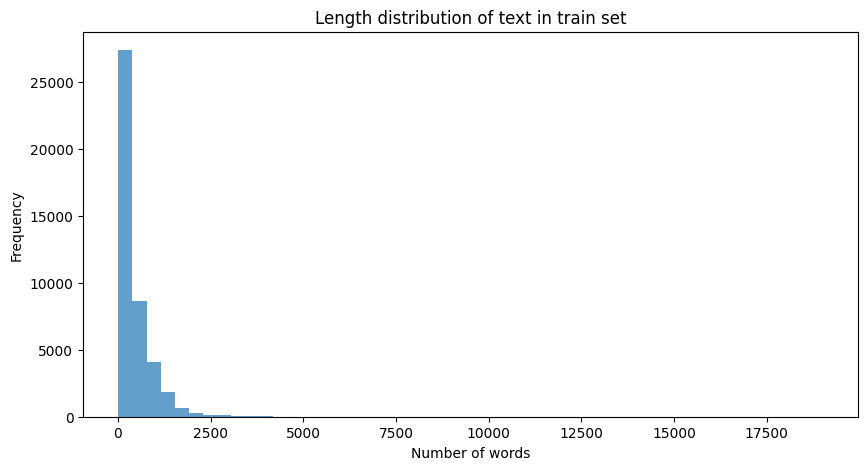

In [ ]:
plot_len_dist(train_data, 'text', 'train')

Statistics for text in validation set:
Mean length: 379.05
Standard deviation: 252.01
90th percentile: 782.00
95th percentile: 915.10
99th percentile: 1069.04


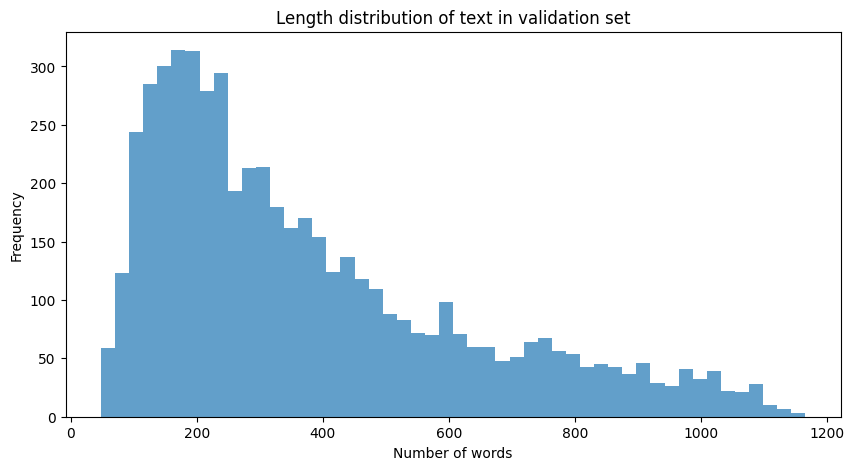

In [ ]:
plot_len_dist(val_data, 'text', 'validation')

Statistics for text in test set:
Mean length: 378.15
Standard deviation: 257.70
90th percentile: 790.20
95th percentile: 935.00
99th percentile: 1085.00


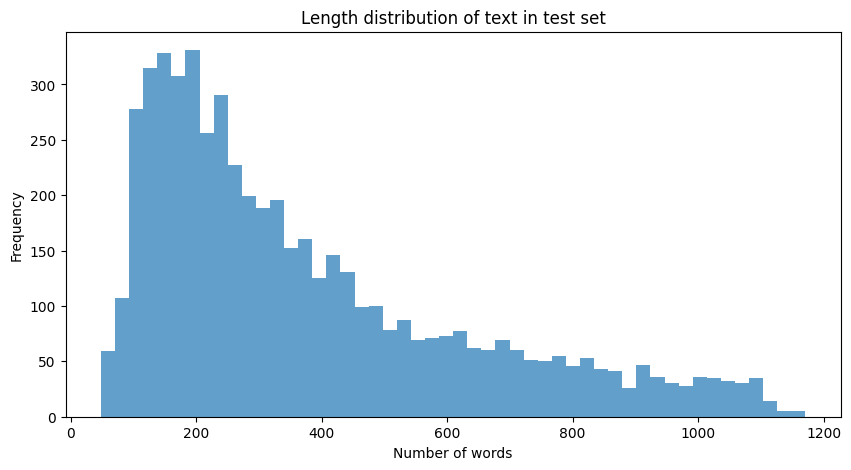

In [ ]:
plot_len_dist(test_data, 'text', 'test')

Statistics for summary in train set:
Mean length: 21.62
Standard deviation: 9.02
90th percentile: 32.00
95th percentile: 37.00
99th percentile: 50.00


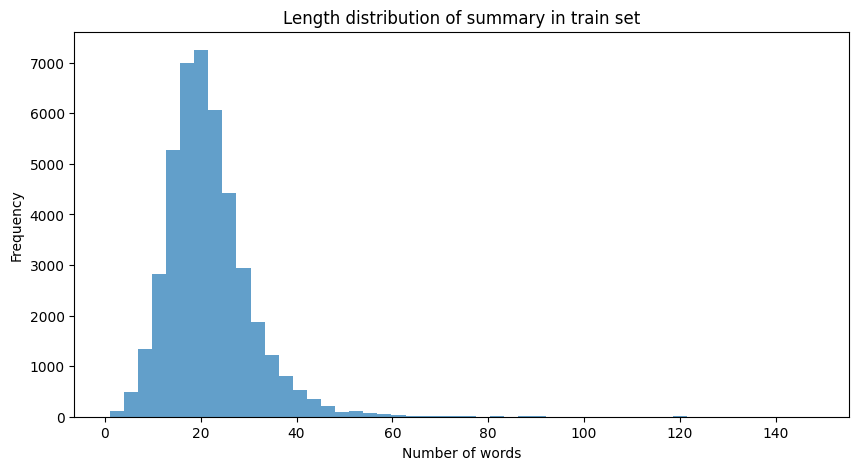

In [ ]:
plot_len_dist(train_data, 'summary', 'train')

Statistics for summary in validation set:
Mean length: 20.27
Standard deviation: 6.49
90th percentile: 29.00
95th percentile: 32.00
99th percentile: 37.00


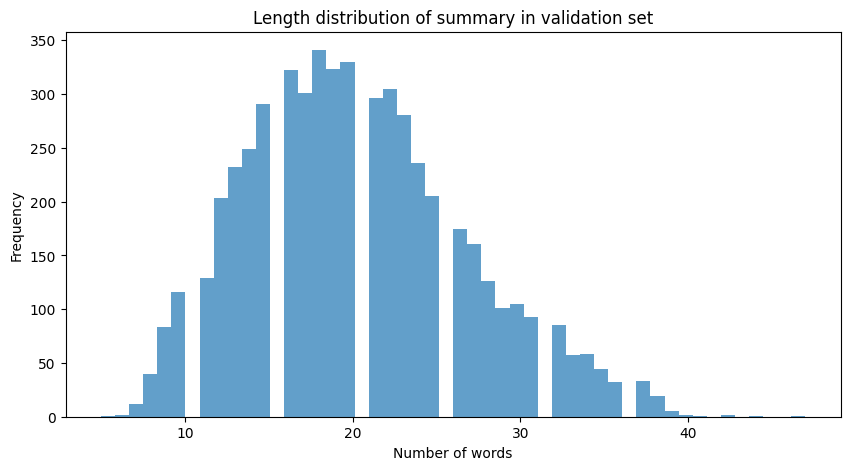

In [ ]:
plot_len_dist(val_data, 'summary', 'validation')

Statistics for summary in test set:
Mean length: 20.25
Standard deviation: 6.39
90th percentile: 29.00
95th percentile: 32.00
99th percentile: 37.00


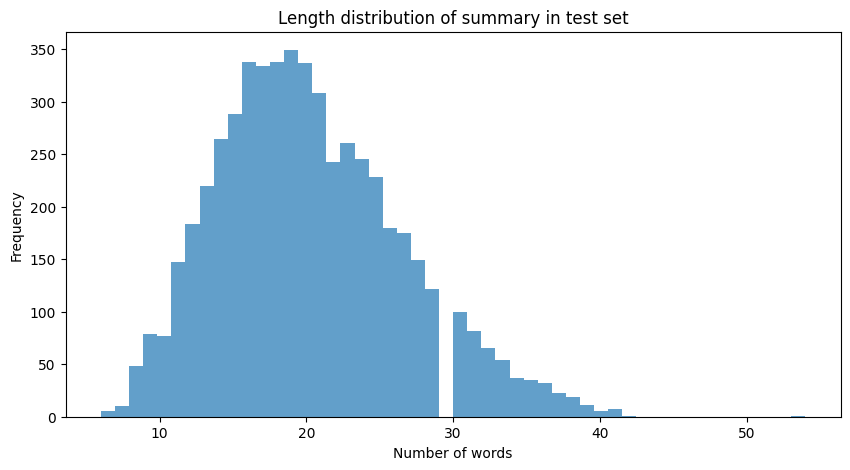

In [ ]:
plot_len_dist(test_data, 'summary', 'test')

In [ ]:
def plot_summary_text_ratio(dataset):
  ratios = [len(record['summary'].split()) / len(record['text'].split()) for record in dataset if len(record['text']) > 0]

  plt.hist(ratios, bins=50)
  plt.title('Summary-to-Text Ratio Distribution')
  plt.xlabel('Summary Length / Text Length')
  plt.ylabel('Frequency')
  plt.show()

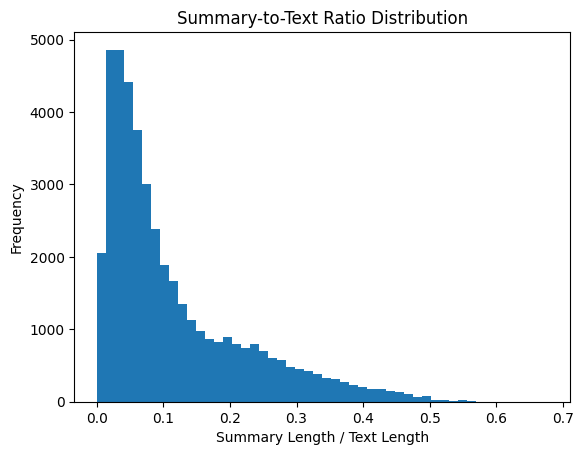

In [ ]:
plot_summary_text_ratio(train_data)

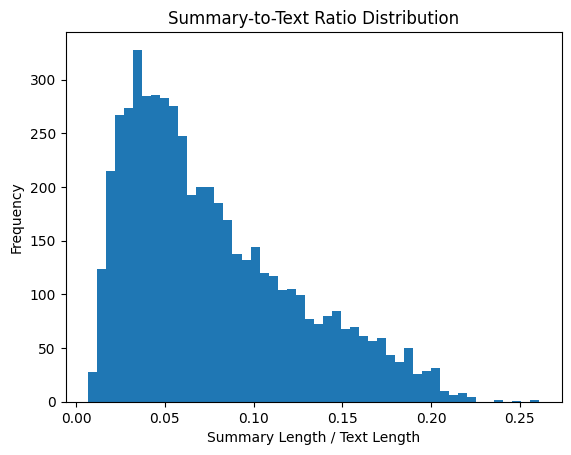

In [ ]:
plot_summary_text_ratio(val_data)

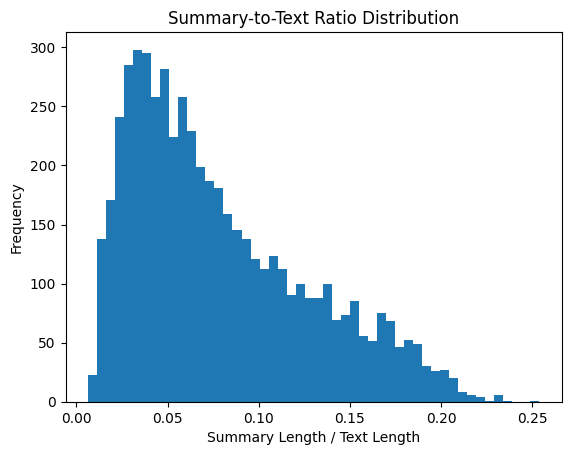

In [ ]:
plot_summary_text_ratio(test_data)

The majority of ratios do not exceed $0.05$ for all three sets; however, there are outliers in train set that aren't present in other sets.

## Duplicates

In [ ]:
# Detect duplicates based on text
unique_texts = len(set(record['text'] for record in train_data))
print(f"Number of unique texts: {unique_texts}")

Number of unique texts: 43121


In [ ]:
unique_summaries = len(set(record['summary'] for record in train_data))
print(f"Number of unique summaries: {unique_summaries}")

Number of unique summaries: 42843


In [ ]:
def find_common_summaries(data: List[dict]) -> List[tuple]:
    # Dictionary to store summaries as keys and list of associated texts as values
    summary_to_texts = defaultdict(list)

    # Populate the dictionary
    for record in data:
        summary_to_texts[record['summary']].append(record['text'])

    # Filter out summaries with more than one distinct text
    common_summaries = [(summary, texts) for summary, texts in summary_to_texts.items() if len(set(texts)) > 1]

    return common_summaries

def find_common_texts(data: List[dict]) -> List[tuple]:
    # Dictionary to store texts as keys and list of associated summaries as values
    text_to_summaries = defaultdict(list)

    # Populate the dictionary
    for record in data:
        text_to_summaries[record['text']].append(record['summary'])

    # Filter out texts with more than one distinct summary
    common_texts = [(text, summaries) for text, summaries in text_to_summaries.items() if len(set(summaries)) > 1]

    return common_texts

In [ ]:
common_summaries = find_common_summaries(train_data)

In [ ]:
len(common_summaries)

200

In [ ]:
common_summaries[0][0]

"Міністерство закордонних справ Росії висловило обурення рішенням депутатів Львівської міської ради про створення комісії для визначення переліку пам'ятників і символів радянського минулого, які необхідно демонтувати."

In [ ]:
common_summaries[0][1][0]

'У коментарі, оприлюдненому на вебсайті МЗС Росії, висловлюється обурення тим, що названо спробами «заробляти політичні очки на боротьбі з пам\'ятниками» та «знущанні над пам\'яттю полеглих». МЗС називає рішення «провокаційною витівкою» і закликає українську владу і громадськість, як сказано, «дати їм відсіч». КПУ засудила рішення Львівради, а віце-спікер розпущеної ВР Адам Мартинюк пригрозив розпустити міську раду Львова. Львівська міська рада на засіданні 10 травня підтримала заяву фракції Всеукраїнського об\'єднання "Свобода" про створення депутатської комісії, яка б визначила, які символи "імперсько-більшовицького панування" можуть бути демонтовані в місті. Водночас Львівська міська рада не ухвалила конкретного рішення про демонтування радянських пам’ятників. Як повідомили у фракції Всеукраїнського об\'єднання "Свобода", до комісії, яка здійснюватиме інвентаризацію пам’ятників, будуть включені архітектори та мистецтвознавці, а після інвентаризації мають відбутися громадські слуханн

In [ ]:
common_summaries[0][1][1]

'У коментарі, оприлюдненому на вебсайті МЗС Росії, висловлюється обурення тим, що названо спробами «заробляти політичні очки на боротьбі з пам\'ятниками» та «знущанні над пам\'яттю полеглих». МЗС називає рішення «провокаційною витівкою» і закликає українську владу і громадськість, як сказано, «дати їм відсіч». Львівська міська рада на засіданні 10 травня підтримала заяву фракції Всеукраїнського об\'єднання "Свобода" про створення депутатської комісії, яка б визначила, які символи "імперсько-більшовицького панування" можуть бути демонтовані в місті. Водночас Львівська міська рада не ухвалила конкретного рішення про демонтування радянських пам’ятників. Як повідомили у фракції Всеукраїнського об\'єднання "Свобода", до комісії, яка здійснюватиме інвентаризацію пам’ятників, будуть включені архітектори та мистецтвознавці, а після інвентаризації мають відбутися громадські слухання.'

The texts are very similar, but with a slight difference: sentence **КПУ засудила рішення Львівради, а віце-спікер розпущеної ВР Адам Мартинюк пригрозив розпустити міську раду Львова.**, present in the first text, is absent from the second one.

In [ ]:
common_summaries[7][0]

"У п'ятницю, 17 лютого, набуває чинності розпорядження уряду про надзвичайні заходи в електроенергетиці."

In [ ]:
common_summaries[7][1][0]

'У Кабміні пояснили це блокуванням перевезень вугілля антрацитної групи з непідконтрольних Києву територій. Там також попередили про можливі "віялові" відключення електроенергії, яких уряд намагатиметься уникнути, та проблеми у металургії із негативними наслідками для економіки. Активісти кажуть, що продовжуватимуть блокаду. Вони вважають, що дії влади якраз свідчать про те, що вони "на вірному шляху". Так активісти начебто перекривають корупційні зв\'язки між офіційним Києвом і неконтрольованою територією. ВВС Україна зібрала кілька питань, що постали у зв\'язку із надзвичайними заходами, які поки що залишаються без однозначної відповіді. 1. Режим НЗ. Кому і коли вимикатимуть електрику? Згідно із розпорядженням, НЗ в електроенергетиці запроваджені на місяць. Після цього вони можуть бути подовжені ще на місяць. Тобто до середини квітня, коли і завершується опалювальний сезон. Головна мета НЗ - мінімізувати споживання антрациту, левову частку якого Україна отримує з непідконтрольних тер

In [ ]:
common_summaries[7][1][1]

'Діяти такий стан буде місяць. Рішення ухвалили через блокування вугілля антрацитної групи з Донбасу, аби забезпечити безперебійну роботу енергетичної системи. В уряді повідомили, що це допоможе збалансувати виробництво і споживання електроенергії. За даними "Укренерго", нинішніх запасів антрациту вистачить для роботи енергосистеми на 40 діб. У Кабміні попередили про можливі "віялові" відключення електроенергії.'

This time we have completely different texts on the same topic. Note, however, that the ground truth summary is very poor; it contains a date (**17 лютого**) that is not mentioned anywhere in the texts.

In [ ]:
common_texts = find_common_texts(train_data)

In [ ]:
len(common_texts)

5

In [ ]:
common_texts[0][0], common_texts[0][1][0], common_texts[0][1][1]

('Кінець YouTube допису, 1 Ви також можете подивитись випуск на YouTube. Всі випуски новин на YouTube. І підписуйтеся на наш Youtube-канал!',
 'У випуску 2 квітня:',
 'У випуску 15 квітня:')

Unfortunately, we can see that there are some trash summaries in the dataset. Moreover, there is no way to filter these based on metadata; one would have to manually discard bad articles. Since the project is done by two people only, this step shall be skipped.

In [ ]:
def find_identical_pairs(data: List[dict]) -> List[dict]:
  text_summary_pairs = set()
  identical_pairs = []

  for record in data:
    pair = (record['text'], record['summary'])

    if pair in text_summary_pairs:
      identical_pairs.append(record)

    text_summary_pairs.add(pair)

  return identical_pairs

In [ ]:
# Example usage
identical_pairs_train = find_identical_pairs(train_data)
identical_pairs_val = find_identical_pairs(val_data)
identical_pairs_test = find_identical_pairs(test_data)

In [ ]:
len(identical_pairs_train), len(identical_pairs_val), len(identical_pairs_test)

(0, 0, 0)

No two pairs are exactly identical (either the texts or summaries differ).

## Language Identification

The dataset authors report to have identified Russian texts within dataset (using Fasttext) and remove the corresponding articles. However, let's see if the results are satisfactory.

In [ ]:
# Detect language inconsistencies
non_ukrainian = [record for record in train_data if langid.classify(record['text'])[0] != 'uk']
print(f"Number of non-Ukrainian texts: {len(non_ukrainian)}")

Number of non-Ukrainian texts: 25


We can see below that although Russian texts were probably filtered successfully, there still are English texts in the dataset.

In [ ]:
non_ukrainian[0]

{'id': '150618_blog_double_vision_lisette1_english_ms',
 'url': 'https://www.bbc.com/ukrainian/blogs/2015/06/150618_blog_double_vision_lisette1_english_ms',
 'title': 'Double vision blog: my Ukrainian shovel and salt',
 'summary': 'I recently returned from my latest Spring visit to my friend and her family in the village and Kiev. I timed my visit to coincide with the annual holiday and vegetable planting so we went straight to the village to start digging the rich brown soil and planting potatoes the next day. A fabulous homemade lunch signaled a week of convivial and hospitable eating and drinking until I thought I might burst or at the least need to fast for several days when I got home again.',
 'text': 'When I arrived in Ukraine my suitcase weighed 12 kilos; on my return and a belt hole fatter on my jeans I struggled up the steps into my flat lugging a 23 kilo bag and a bizarre conglomeration of hand luggage. The journey from the airport to Notting Hill on the ‘Tube’ otherwise kno

In [ ]:
non_ukrainian[7]

{'id': 'learningenglish-42555968',
 'url': 'https://www.bbc.com/ukrainian/learningenglish-42555968',
 'title': 'Новий Lingohack - говоримо про кров',
 'summary': 'В черговому уроці англійської мови з циклу Lingohack лінгвісти відділу BBC Learning English пропонують лексику на медичну тему - лікування гемофілії.',
 'text': "Заголовок Haemophilia breakthrough Вивчаємо лексику на тему Haemophilia Корисна лексика: Дайте відповідь на таке питання: What was used to give Jake's body new genetic instructions for clotting blood? Текст Walking two miles to work used to be unthinkable for Jake Omer. He was born with haemophilia A, a genetic defect that means his blood did not clot. The slightest injury used to mean severe bleeding. Even a long stroll would cause bleeding in his joints. But no more. Jake Omer, Haemophiliac “I think the gene therapy has hopefully given me a new lease of life. It's going to allow me, when as my boys grow up, to be a lot more active with them - to kick footballs arou

In [ ]:
non_ukrainian[11]

{'id': 'learningenglish-45277971',
 'url': 'https://www.bbc.com/ukrainian/learningenglish-45277971',
 'title': 'Lingohack - урок англійської про секрети мумій',
 'summary': 'В уроці англійської мови на основі телезаголовків лінгвісти BBC Learning English пропонують поговорити про секрети стародавньої муміфікації.',
 'text': "Новина: The secret recipe for ancient mummification Вивчаємо лексику на тему: Stopping deterioration Корисна лексика: Дайте відповідь на таке питання: Which three ingredients are mentioned as part of the embalming recipe? Текст: Fabric fragments of ancient history. These six-thousand-year-old pieces of linen contain the chemical secret of mummification. The Egyptian Mummy - the body preserved as a vessel for the eternal soul - is an icon of this ancient civilisation. It's been resurrected in many a Hollywood film. But far from Egypt's great tombs, here in a storage facility for Bolton Museum in Northern England, the ancient Egyptians' embalming recipe has finally c

Since we are thinking to use Ukrainian-only models (rather than multilingual ones) we should filter out all the texts written in other languages.

In [ ]:
train_data_ukr = [record for record in train_data if record not in non_ukrainian]

In [ ]:
len(train_data), len(train_data_ukr)

(43201, 43176)

In [ ]:
non_ukrainian_val = [record for record in val_data if langid.classify(record['text'])[0] != 'uk']
print(f"Number of non-Ukrainian texts in validation set: {len(non_ukrainian_val)}")

non_ukrainian_test = [record for record in test_data if langid.classify(record['text'])[0] != 'uk']
print(f"Number of non-Ukrainian texts in test set: {len(non_ukrainian_test)}")

Number of non-Ukrainian texts in validation set: 9
Number of non-Ukrainian texts in test set: 6


In [ ]:
val_data_ukr = [record for record in val_data if record not in non_ukrainian_val]
test_data_ukr = [record for record in test_data if record not in non_ukrainian_test]

In [ ]:
len(val_data), len(val_data_ukr)

(5399, 5390)

In [ ]:
len(test_data), len(test_data_ukr)

(5399, 5393)

In [ ]:
def save_to_jsonl(data: List[dict], file_path: str) -> None:
    with open(file_path, 'w', encoding='utf-8') as f:
        for record in data:
            json.dump(record, f, ensure_ascii=False)
            f.write('\n')  # New line after each JSON object

In [ ]:
os.makedirs('data', exist_ok=True)

In [ ]:
save_to_jsonl(train_data_ukr, 'data/train_data.jsonl')
save_to_jsonl(val_data_ukr, 'data/val_data.jsonl')
save_to_jsonl(test_data_ukr, 'data/test_data.jsonl')

In [ ]:
train_data = load_dataset('data/train_data.jsonl')
val_data = load_dataset('data/val_data.jsonl')
test_data = load_dataset('data/test_data.jsonl')

## Title-Summary Similarity

In [ ]:
def similarity(a, b):
  return SequenceMatcher(None, a, b).ratio()

def plot_similarities(dataset):
  title_summary_similarities = [similarity(record['title'], record['summary']) for record in dataset]

  plt.hist(title_summary_similarities, bins=50)
  plt.title('Title-Summary Similarity Distribution')
  plt.xlabel('Similarity')
  plt.ylabel('Frequency')
  plt.show()

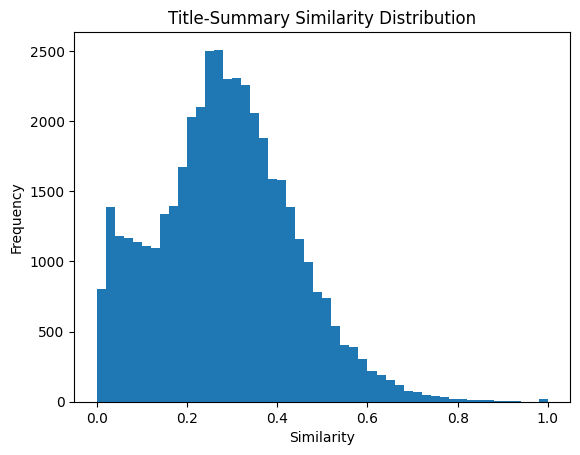

In [ ]:
plot_similarities(train_data)

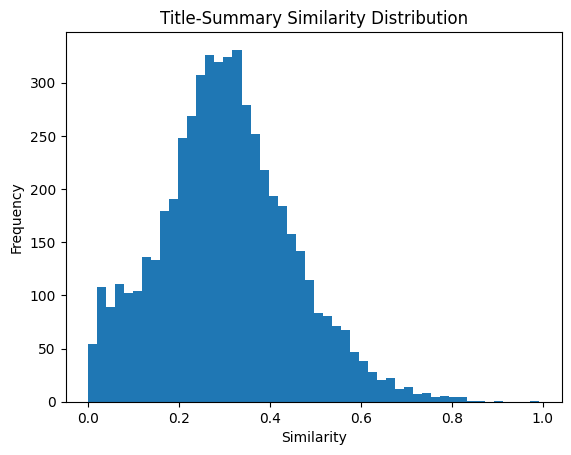

In [ ]:
plot_similarities(val_data)

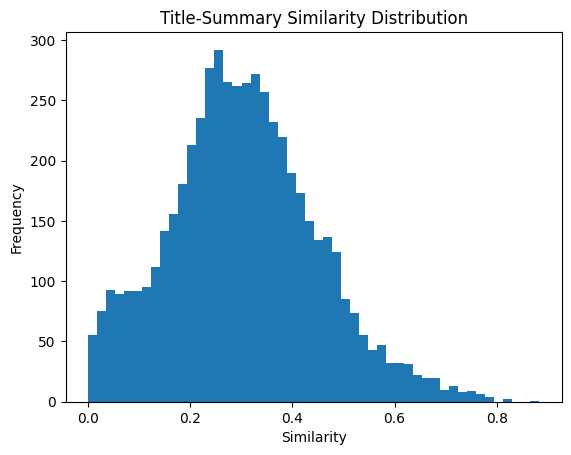

In [ ]:
plot_similarities(test_data)

Interestingly, the degree of similarity between titles and summaries is consistent (even if not high) across different datasets. This indicates some connection between the two.

It is worth noting that most of the records have a low-to-moderate degree of similarity between title and summary ($0.6$ and lower), which is a good sign. Otherwise it would indicate poorly written summaries.

## Word Frequency

In [ ]:
# Get Ukrainian stopwords
ukrainian_stopwords = stopwords.stopwords('uk')

# A minimal list of common Ukrainian stopwords
ukrainian_stopwords.update({
    'і', 'в', 'у', 'на', 'до', 'за', 'з', 'це', 'та', 'що', 'як', 'але', 'так', 'ми', 'ви', 'він', 'вона', 'вони',
    'є', 'бути', 'його', 'її', 'їх', 'тощо', 'або', 'все', 'чи', 'ні', 'я', 'ти', 'ми', 'ми', 'наш', 'нашого', 'не', 'а'
})
# ukrainian_stopwords = set(ukrainian_stopwords)

def show_common_words(dataset):
  # Get word frequencies in the text and summaries
  text_words = Counter([word for record in dataset for word in record['text'].split() if word.lower() not in ukrainian_stopwords])
  summary_words = Counter([word for record in dataset for word in record['summary'].split() if word.lower() not in ukrainian_stopwords])

  # Most common words
  print("Most common words in text:", text_words.most_common(10))
  print("Most common words in summary:", summary_words.most_common(10))

In [ ]:
show_common_words(train_data)

Most common words in text: [('-', 231411), ('які', 58098), ('–', 36810), ('вже', 32357), ('час', 31328), ('року', 29790), ('може', 29713), ('ще', 29512), ('після', 29432), ('те,', 29426)]
Most common words in summary: [('-', 5943), ('України', 3944), ('які', 2711), ('США', 2333), ('Президент', 2097), ('після', 2031), ('щодо', 1960), ('час', 1839), ('Росії', 1810), ('через', 1690)]


In [ ]:
show_common_words(val_data)

Most common words in text: [('-', 23980), ('які', 6227), ('вже', 3538), ('час', 3503), ('–', 3457), ('після', 3421), ('може', 3256), ('року', 3131), ('те,', 3079), ('цього', 3020)]
Most common words in summary: [('-', 625), ('України', 509), ('США', 329), ('які', 303), ('Президент', 273), ('щодо', 259), ('Росії', 257), ('після', 249), ('президента', 224), ('час', 217)]


In [ ]:
show_common_words(test_data)

Most common words in text: [('-', 24489), ('які', 6270), ('–', 3713), ('час', 3596), ('вже', 3415), ('після', 3339), ('року', 3276), ('може', 3240), ('те,', 3146), ('ще', 2973)]
Most common words in summary: [('-', 613), ('України', 475), ('США', 319), ('які', 315), ('Президент', 300), ('Росії', 258), ('після', 252), ('щодо', 248), ('час', 239), ('президента', 231)]


In [ ]:
len(ukrainian_stopwords)

86

In [ ]:
!pip install wordcloud

In [ ]:
from wordcloud import WordCloud

In [ ]:
def plot_word_cloud(dataset):
  text_data = " ".join(record['text'] for record in dataset)
  summary_data = " ".join(record['summary'] for record in dataset)

  wordcloud_text = WordCloud(width=800, height=400).generate(text_data)
  wordcloud_summary = WordCloud(width=800, height=400).generate(summary_data)

  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud_text, interpolation='bilinear')
  plt.axis("off")
  plt.title('Word Cloud for Texts')
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud_summary, interpolation='bilinear')
  plt.axis("off")
  plt.title('Word Cloud for Summaries')
  plt.show()

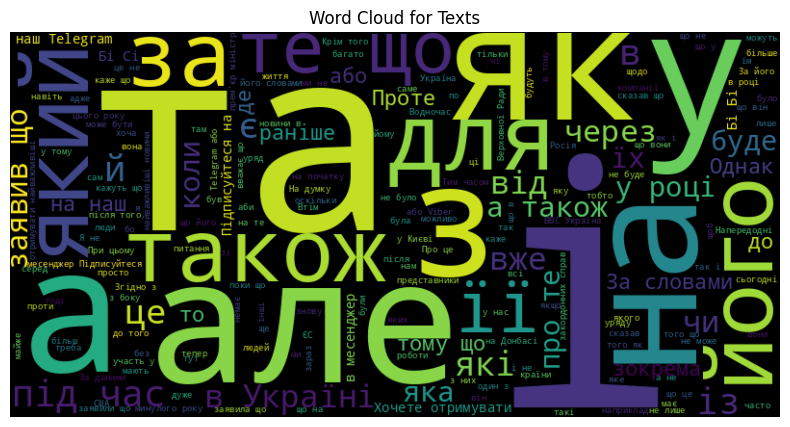

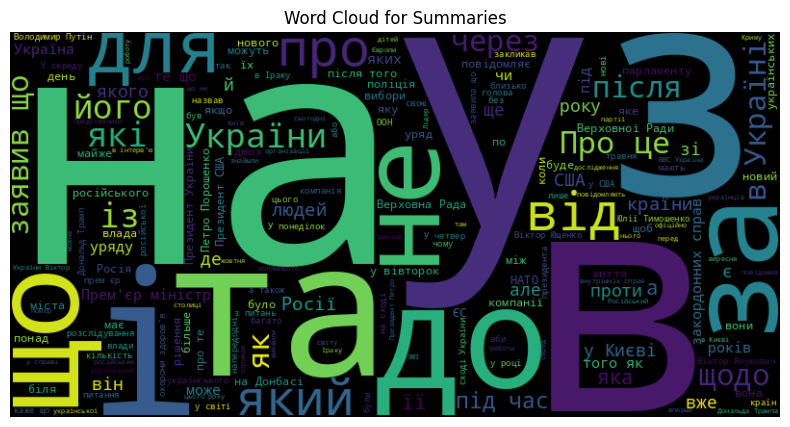

In [ ]:
plot_word_cloud(val_data)

## Readability Analysis

In [ ]:
def plot_readability(dataset):
  readability_scores = [textstat.flesch_reading_ease(record['text']) for record in dataset]

  plt.figure(figsize=(10, 5))
  plt.hist(readability_scores, bins=50)
  plt.title('Distribution of Readability Scores')
  plt.xlabel('Count')
  plt.ylabel('Score')
  plt.show()

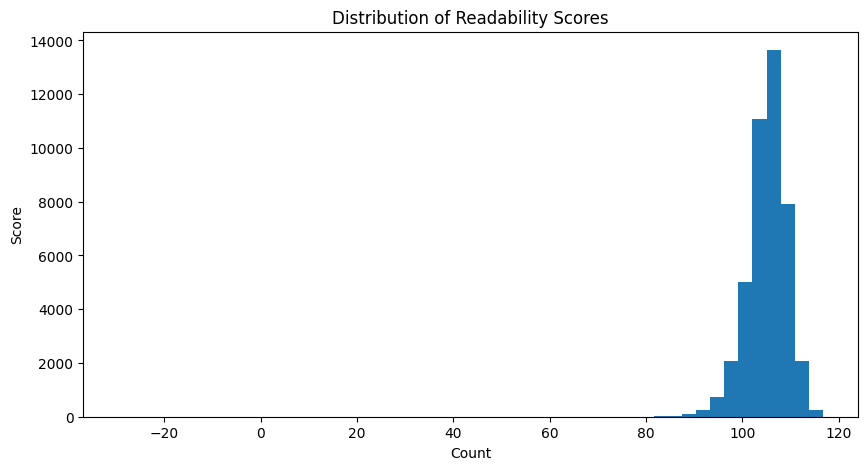

In [ ]:
plot_readability(train_data)

A score of over $80$ means the text is simple; scores above $100$ are extremely simple texts. Probably this means the dataset uses few uncommon words and has easy structure, which should make it simpler for language tasks like summarization.

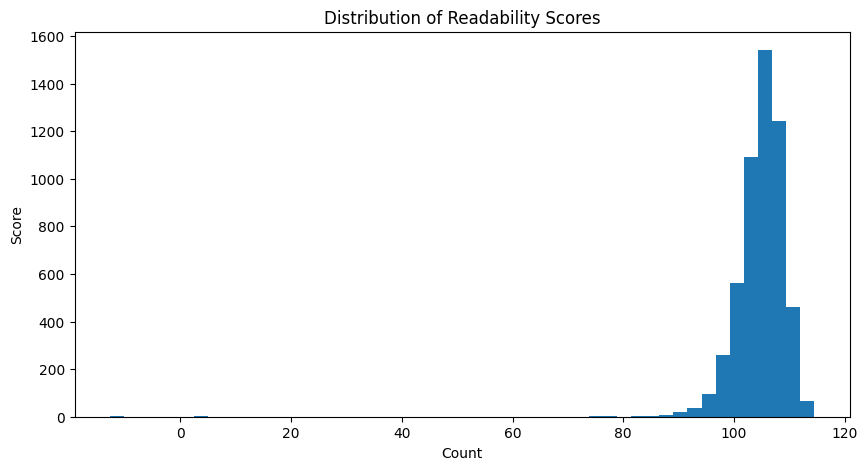

In [ ]:
plot_readability(val_data)

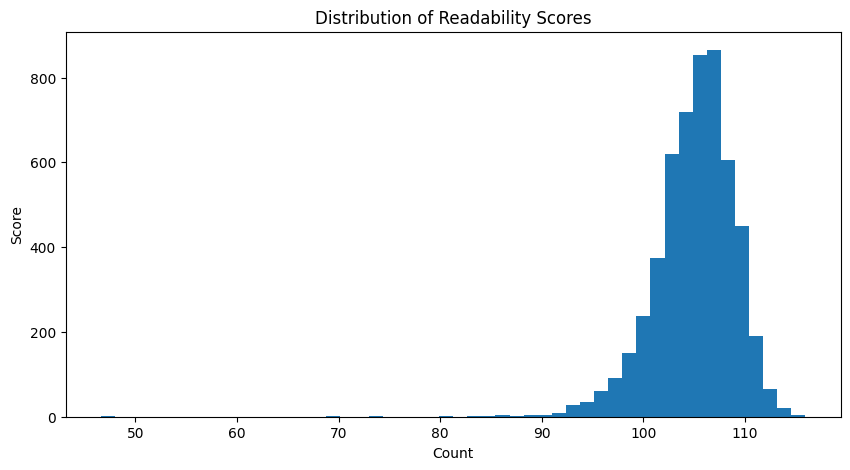

In [ ]:
plot_readability(test_data)